# Library Import Initiation

In [1]:
import pandas as pd
import math
import json
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import numpy

from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import joblib

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
import datetime

# Dataset Import

In [4]:
df1 = pd.read_csv("ad_performance_no_outliers_2.csv")
df2 = pd.read_csv("balanced_output_smote (1).csv")
df3 = pd.read_csv("balanced_output_smote(2).csv")

# Variables Define

In [5]:
num_cols = ["uv", "search", "ocr"]

cat_cols = ["material", "placement", "payment", "sellingpoint"]

# PROCESS FUNCS

## num_cols Scaling

In [6]:
def scale_with_robust_scaler(df, num_cols=num_cols):
    df_scaled = df[num_cols].copy()
    for col in num_cols:
        scaler_path = os.path.join("scalers", f"{col}_robust_scaler.pkl")
        scaler = joblib.load(scaler_path)
        df_scaled[col] = scaler.transform(df[[col]])
    return df_scaled

## cat_cols OneHotEncoding

In [7]:
def onehotencoding_with_encoder(df, cat_cols=cat_cols):
    df_cat = df[cat_cols].copy()
    # 加载已保存的OneHotEncoder
    encoder = joblib.load('onehot_encoder.pkl')

    # 对新数据进行编码（只需包含main_cat_cols的列）
    new_cat_encoded = encoder.transform(df_cat[cat_cols])

    # 转为DataFrame，列名与训练时一致
    new_cat_encoded_df = pd.DataFrame(
        new_cat_encoded,
        columns=encoder.get_feature_names_out(cat_cols),
        index=df_cat.index
    )
    return new_cat_encoded_df

## cat_cols Labelencoding

In [8]:
def encode_with_label_mapping(df, cat_cols, mapping_path='label_mapping.json'):
    # 读取映射文件
    with open(mapping_path, 'r', encoding='utf-8') as f:
        label_mapping = json.load(f)
    df_encoded = df[cat_cols].copy()
    for col in cat_cols:
        if col in label_mapping:
            df_encoded[col] = df_encoded[col].map(label_mapping[col])
        else:
            raise ValueError(f"列 {col} 不在 label_mapping.json 中")
    return df_encoded


## Merge dfs

In [9]:
def dataset_processing(dataf,label_method):
    num_df = scale_with_robust_scaler(dataf)
    if label_method == "onehot":
        cat_df = onehotencoding_with_encoder(dataf)
    elif label_method == "label":
        cat_df = encode_with_label_mapping(dataf, cat_cols)
    df_reg = pd.concat([num_df, cat_df], axis=1)
    df_moc = df_reg.drop(columns="ocr", axis=1)
    return df_moc, df_reg

# DATA SETS BUILDING

In [10]:
df_transformer_moc, df_xgb_reg = dataset_processing(df3, label_method="label")

# MOC-TabTransformer

## Model Defination

In [11]:
X_transformer = df_transformer_moc[['uv', 'search']]
y_transformer = df_transformer_moc[['material', 'placement', 'payment', 'sellingpoint']]

In [12]:
X_trf_train, X_trf_test, y_trf_train, y_trf_test = train_test_split(
    X_transformer, y_transformer, test_size=0.2, random_state=688
)

In [13]:
# 特征（numpy array）
X_train = X_trf_train[['uv', 'search']].values.astype(np.float32)
X_test = X_trf_test[['uv', 'search']].values.astype(np.float32)

# 多头输出（int标签）
y_material_train = y_trf_train['material'].values
y_placement_train = y_trf_train['placement'].values
y_payment_train = y_trf_train['payment'].values
y_sellingpoint_train = y_trf_train['sellingpoint'].values

y_material_test = y_trf_test['material'].values
y_placement_test = y_trf_test['placement'].values
y_payment_test = y_trf_test['payment'].values
y_sellingpoint_test = y_trf_test['sellingpoint'].values

# 各标签类别数量
material_dim = len(np.unique(y_material_train))
placement_dim = len(np.unique(y_placement_train))
payment_dim = len(np.unique(y_payment_train))
sellingpoint_dim = len(np.unique(y_sellingpoint_train))

In [14]:
input_dim = X_train.shape[1]
inputs = keras.Input(shape=(input_dim,))

x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)

material_out = layers.Dense(material_dim, activation='softmax', name='material')(x)
placement_out = layers.Dense(placement_dim, activation='softmax', name='placement')(x)
payment_out = layers.Dense(payment_dim, activation='softmax', name='payment')(x)
sellingpoint_out = layers.Dense(sellingpoint_dim, activation='softmax', name='sellingpoint')(x)

model = keras.Model(inputs=inputs, outputs=[material_out, placement_out, payment_out, sellingpoint_out])

## GridSearch

In [15]:
from tensorflow.keras import backend as K
import gc

# 清除 Keras/TensorFlow 会话
K.clear_session()

# 强制进行垃圾回收，释放未引用的对象
gc.collect()

0

In [16]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
import json

def build_model(input_dim, material_dim, placement_dim, payment_dim, sellingpoint_dim, dense1=128, dense2=64, lr=0.001):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(dense1, activation='relu')(inputs)
    x = layers.Dense(dense2, activation='relu')(x)
    material_out = layers.Dense(material_dim, activation='softmax', name='material')(x)
    placement_out = layers.Dense(placement_dim, activation='softmax', name='placement')(x)
    payment_out = layers.Dense(payment_dim, activation='softmax', name='payment')(x)
    sellingpoint_out = layers.Dense(sellingpoint_dim, activation='softmax', name='sellingpoint')(x)
    model = keras.Model(inputs=inputs, outputs=[material_out, placement_out, payment_out, sellingpoint_out])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss={
            'material': 'sparse_categorical_crossentropy',
            'placement': 'sparse_categorical_crossentropy',
            'payment': 'sparse_categorical_crossentropy',
            'sellingpoint': 'sparse_categorical_crossentropy',
        },
        metrics={
            'material': 'accuracy',
            'placement': 'accuracy',
            'payment': 'accuracy',
            'sellingpoint': 'accuracy',
        }
    )
    return model

param_grid = {
    'dense1': [64, 128],
    'dense2': [32, 64],
    'lr': [0.001, 0.0005]
}

best_score = -1
best_params = None

kf = KFold(n_splits=3, shuffle=True, random_state=42)
for dense1 in param_grid['dense1']:
    for dense2 in param_grid['dense2']:
        for lr in param_grid['lr']:
            scores = []
            for train_idx, val_idx in kf.split(X_train):
                X_tr, X_val = X_train[train_idx], X_train[val_idx]
                y_tr_material = y_material_train[train_idx]
                y_tr_placement = y_placement_train[train_idx]
                y_tr_payment = y_payment_train[train_idx]
                y_tr_sellingpoint = y_sellingpoint_train[train_idx]
                y_val_material = y_material_train[val_idx]
                y_val_placement = y_placement_train[val_idx]
                y_val_payment = y_payment_train[val_idx]
                y_val_sellingpoint = y_sellingpoint_train[val_idx]

                model_cv = build_model(input_dim, material_dim, placement_dim, payment_dim, sellingpoint_dim, dense1, dense2, lr)
                early_stop_cv = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                history_cv = model_cv.fit(
                    X_tr,
                    {
                        'material': y_tr_material,
                        'placement': y_tr_placement,
                        'payment': y_tr_payment,
                        'sellingpoint': y_tr_sellingpoint,
                    },
                    validation_data=(
                        X_val,
                        {
                            'material': y_val_material,
                            'placement': y_val_placement,
                            'payment': y_val_payment,
                            'sellingpoint': y_val_sellingpoint,
                        }
                    ),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop_cv],
                    verbose=0
                )
                val_pred = model_cv.predict(X_val)
                val_pred_material = val_pred[0].argmax(axis=1)
                acc = (val_pred_material == y_val_material).mean()
                scores.append(acc)
            avg_score = np.mean(scores)
            print(f'dense1={dense1}, dense2={dense2}, lr={lr}, avg_acc={avg_score:.4f}')
            if avg_score > best_score:
                best_score = avg_score
                best_params = {'dense1': dense1, 'dense2': dense2, 'lr': lr}
                
with open('BestParamsTabMOC.json', 'w', encoding='utf-8') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

print("Best params:", best_params)

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
dense1=64, dense2=32, lr=0.001, avg_acc=0.8372
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
dense1=64, dense2=32, lr=0.0005, avg_acc=0.8306
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
dense1=64, dense2=64, lr=0.001, avg_acc=0.8413
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
dense1=64, dense2=64, lr=0.0005, avg_acc=0.8372
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
dense1=128, dense2=32, lr=0.001, avg_acc=0.8423
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
dense1=128, dense2=32, lr=

## Model Train

** Best params: {'dense1': 128, 'dense2': 64, 'lr': 0.001}

In [17]:
def loss_curve_plot(model_history, train_time, plt_title=None):
    plt.figure(figsize=(10, 4))
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    if plt_title:
        plt.title(plt_title)
    else:
        plt.title(f'TabTransformer-MOC Training & Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

# Build model architecture
inputs = keras.Input(shape=(X_train.shape[1],), name='input_layer')

x = layers.Dense(best_params['dense1'], activation='relu', name='dense1')(inputs)
x = layers.Dense(best_params['dense2'], activation='relu', name='dense2')(x)

# Multi-output branches, one softmax layer for each task
num_classes_material = len(np.unique(y_material_train))
num_classes_placement = len(np.unique(y_placement_train))
num_classes_payment = len(np.unique(y_payment_train))
num_classes_sellingpoint = len(np.unique(y_sellingpoint_train))

material_out = layers.Dense(num_classes_material, activation='softmax', name='material')(x)
placement_out = layers.Dense(num_classes_placement, activation='softmax', name='placement')(x)
payment_out = layers.Dense(num_classes_payment, activation='softmax', name='payment')(x)
sellingpoint_out = layers.Dense(num_classes_sellingpoint, activation='softmax', name='sellingpoint')(x)

# Build model
final_model = keras.Model(
    inputs=inputs,
    outputs=[material_out, placement_out, payment_out, sellingpoint_out]
)

# Compile model
final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_params['lr']),
    loss={
        'material': 'sparse_categorical_crossentropy',
        'placement': 'sparse_categorical_crossentropy',
        'payment': 'sparse_categorical_crossentropy',
        'sellingpoint': 'sparse_categorical_crossentropy',
    },
    metrics={
        'material': 'accuracy',
        'placement': 'accuracy',
        'payment': 'accuracy',
        'sellingpoint': 'accuracy',
    }
)

# Early stopping callback
final_early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train model
final_history = final_model.fit(
    X_train,
    {
        'material': y_material_train,
        'placement': y_placement_train,
        'payment': y_payment_train,
        'sellingpoint': y_sellingpoint_train,
    },
    validation_data=(
        X_test,
        {
            'material': y_material_test,
            'placement': y_placement_test,
            'payment': y_payment_test,
            'sellingpoint': y_sellingpoint_test,
        }
    ),
    epochs=1000,
    batch_size=32,
    callbacks=[final_early_stop],
    verbose=1
)

Epoch 1/1000
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.5896 - material_accuracy: 0.7200 - material_loss: 0.7492 - payment_accuracy: 0.5038 - payment_loss: 1.1591 - placement_accuracy: 0.4426 - placement_loss: 1.2094 - sellingpoint_accuracy: 0.4547 - sellingpoint_loss: 1.4719 - val_loss: 3.7749 - val_material_accuracy: 0.7565 - val_material_loss: 0.5492 - val_payment_accuracy: 0.6011 - val_payment_loss: 0.9937 - val_placement_accuracy: 0.5764 - val_placement_loss: 1.0253 - val_sellingpoint_accuracy: 0.5933 - val_sellingpoint_loss: 1.2067
Epoch 2/1000
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 3.6701 - material_accuracy: 0.7582 - material_loss: 0.5257 - payment_accuracy: 0.6307 - payment_loss: 0.9463 - placement_accuracy: 0.5679 - placement_loss: 0.9980 - sellingpoint_accuracy: 0.5767 - sellingpoint_loss: 1.2001 - val_loss: 3.5796 - val_material_accuracy: 0.7756 - val_material_loss: 0.5118 - val_payment_accuracy: 0.6133 - val_payment_loss: 0.9371 - val_placement_accuracy

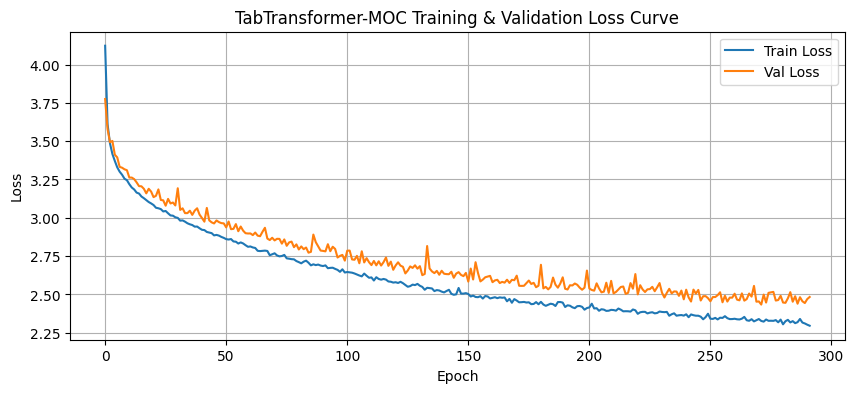

In [20]:
train_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
loss_curve_plot(final_history, train_time)

Original model best validation loss: 2.433889
Epoch 1/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2872 - material_accuracy: 0.8829 - material_loss: 0.2717 - payment_accuracy: 0.7698 - payment_loss: 0.5994 - placement_accuracy: 0.7582 - placement_loss: 0.6329 - sellingpoint_accuracy: 0.7243 - sellingpoint_loss: 0.7832 - val_loss: 2.4048 - val_material_accuracy: 0.8633 - val_material_loss: 0.3071 - val_payment_accuracy: 0.7539 - val_payment_loss: 0.6249 - val_placement_accuracy: 0.7300 - val_placement_loss: 0.6778 - val_sellingpoint_accuracy: 0.7274 - val_sellingpoint_loss: 0.7950
Epoch 2/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 2.2347 - material_accuracy: 0.8842 - material_loss: 0.2725 - payment_accuracy: 0.7801 - payment_loss: 0.5766 - placement_accuracy: 0.7644 - placement_loss: 0.6087 - sellingpoint_accuracy: 0.7222 - sellingpoint_loss: 0.7769 - val_loss: 2.3994 - val_material_accuracy: 0.8628 - val_material_loss: 0.3056 - val_payment_accuracy: 0.7543 - val_pay

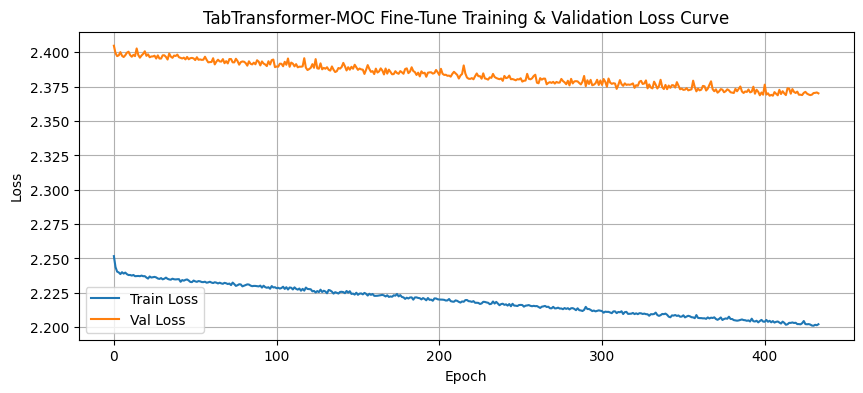

Model validation loss before fine-tuning: 2.433889
Model validation loss after fine-tuning: 2.368433
Improvement percentage: 2.69%


In [21]:
retrain_params = {
    'lr': 0.0001,  # Use a smaller learning rate for fine-tuning
    'batch_size': 128  # Use a larger batch size
}

# Save the current model's performance metrics as a baseline
original_val_loss = min(final_history.history['val_loss'])
print(f"Original model best validation loss: {original_val_loss:.6f}")

# Fine-tune the current model with a smaller learning rate (using the same model structure, but update the optimizer)
final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=retrain_params['lr']),  # Only update the learning rate
    loss={
        'material': 'sparse_categorical_crossentropy',
        'placement': 'sparse_categorical_crossentropy',
        'payment': 'sparse_categorical_crossentropy',
        'sellingpoint': 'sparse_categorical_crossentropy',
    },
    metrics={
        'material': 'accuracy',
        'placement': 'accuracy',
        'payment': 'accuracy',
        'sellingpoint': 'accuracy',
    }
)

# Create a new early stopping callback with more patience to accommodate the smaller learning rate
retrain_early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=30,  # Increase patience value
    restore_best_weights=True,
    verbose=1
)

# Continue training the model using the same training and testing data
finetune_history = final_model.fit(
    X_train,
    {
        'material': y_material_train,
        'placement': y_placement_train,
        'payment': y_payment_train,
        'sellingpoint': y_sellingpoint_train,
    },
    validation_data=(
        X_test,
        {
            'material': y_material_test,
            'placement': y_placement_test,
            'payment': y_payment_test,
            'sellingpoint': y_sellingpoint_test,
        }
    ),
    epochs=1000,  # Set a large number of epochs, rely on early stopping for control
    batch_size=retrain_params['batch_size'],
    callbacks=[retrain_early_stop],
    verbose=1
)

# Plot the loss curve after fine-tuning
finetune_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
loss_curve_plot(finetune_history, finetune_time, plt_title="TabTransformer-MOC Fine-Tune Training & Validation Loss Curve")

# Print comparison of validation loss before and after fine-tuning
finetune_val_loss = min(finetune_history.history['val_loss'])
print(f"Model validation loss before fine-tuning: {original_val_loss:.6f}")
print(f"Model validation loss after fine-tuning: {finetune_val_loss:.6f}")
print(f"Improvement percentage: {(original_val_loss - finetune_val_loss) / original_val_loss * 100:.2f}%")

## Evaluation

In [22]:
# 预测
y_pred = final_model.predict(X_test)
y_pred_material = y_pred[0].argmax(axis=1)
y_pred_placement = y_pred[1].argmax(axis=1)
y_pred_payment = y_pred[2].argmax(axis=1)
y_pred_sellingpoint = y_pred[3].argmax(axis=1)

# 评估准确率
print(f'TabTransformer-MOC Evaluation({best_params}):')
print('Train Time:', train_time)
print("Material acc:", np.mean(y_pred_material == y_material_test))
print("Placement acc:", np.mean(y_pred_placement == y_placement_test))
print("Payment acc:", np.mean(y_pred_payment == y_payment_test))
print("Sellingpoint acc:", np.mean(y_pred_sellingpoint == y_sellingpoint_test))

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
TabTransformer-MOC Evaluation({'dense1': 128, 'dense2': 64, 'lr': 0.001}):
Train Time: 2025-08-02 23:34:05
Material acc: 0.8650173611111112
Placement acc: 0.7408854166666666
Payment acc: 0.7556423611111112
Sellingpoint acc: 0.7235243055555556


In [23]:
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize


# y_pred是概率分布，y_material_test等为int标签
# 先将真实标签转为one-hot
y_true_material_oh = label_binarize(y_material_test, classes=np.arange(material_dim))
y_true_placement_oh = label_binarize(y_placement_test, classes=np.arange(placement_dim))
y_true_payment_oh = label_binarize(y_payment_test, classes=np.arange(payment_dim))
y_true_sellingpoint_oh = label_binarize(y_sellingpoint_test, classes=np.arange(sellingpoint_dim))

# 取概率输出
y_pred_material_proba = y_pred[0]
y_pred_placement_proba = y_pred[1]
y_pred_payment_proba = y_pred[2]
y_pred_sellingpoint_proba = y_pred[3]

# 计算每个头的AP
ap_material = average_precision_score(y_true_material_oh, y_pred_material_proba, average='macro')
ap_placement = average_precision_score(y_true_placement_oh, y_pred_placement_proba, average='macro')
ap_payment = average_precision_score(y_true_payment_oh, y_pred_payment_proba, average='macro')
ap_sellingpoint = average_precision_score(y_true_sellingpoint_oh, y_pred_sellingpoint_proba, average='macro')

# 计算mAP
mAP = np.mean([ap_material, ap_placement, ap_payment, ap_sellingpoint])
print(f"TabTransformer-MOC Test set mAP: {mAP:.4f}")


TabTransformer-MOC Test set mAP: 0.8165


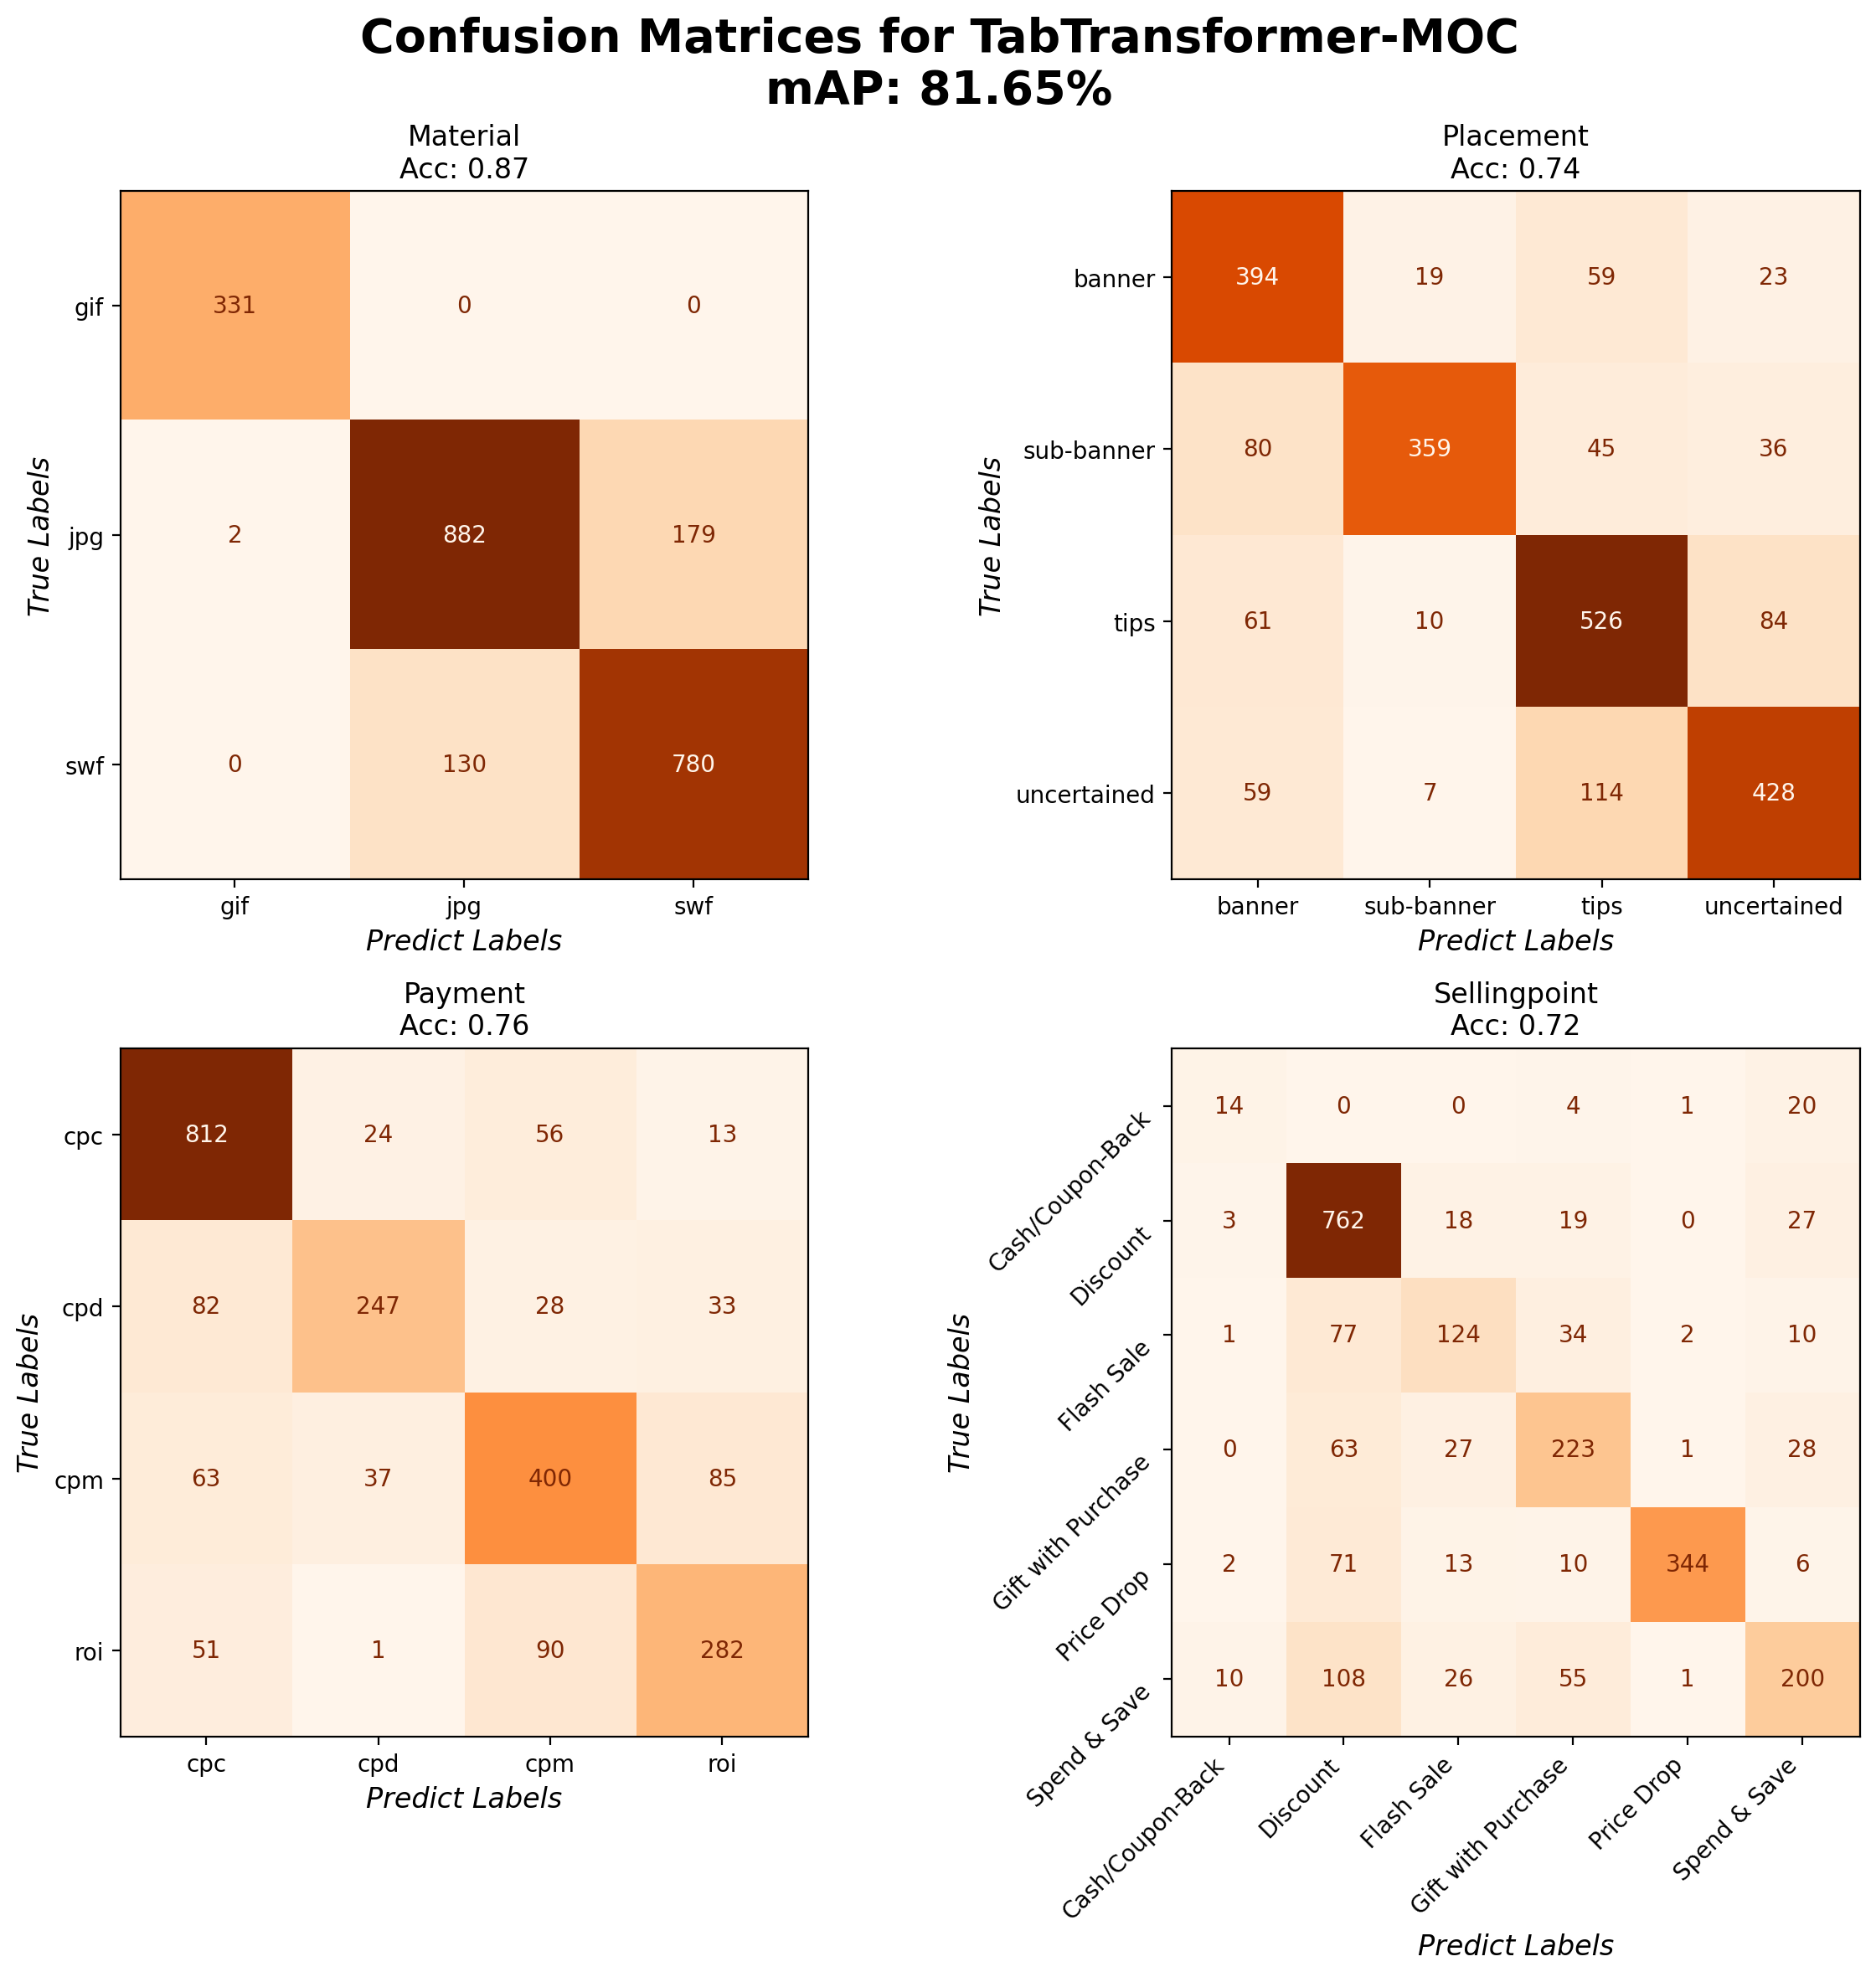

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

def safe_confusion_matrix_display(cm, labels, ax, title, acc):
    n = cm.shape[0]
    if len(labels) > n:
        labels = labels[:n]
    elif len(labels) < n:
        labels = labels + [f'class_{i}' for i in range(len(labels), n)]
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(ax=ax, cmap='Oranges', colorbar=False)
    ax.set_title(title)
    ax.set_xlabel('Predict Labels', fontsize=12, fontstyle='italic')
    ax.set_ylabel('True Labels', fontsize=12, fontstyle='italic')
    ax.grid(False)

# 预测类别
y_pred_material_cls = y_pred[0].argmax(axis=1)
y_pred_placement_cls = y_pred[1].argmax(axis=1)
y_pred_payment_cls = y_pred[2].argmax(axis=1)
y_pred_sellingpoint_cls = y_pred[3].argmax(axis=1)

# 真实类别
y_true_material_cls = y_material_test
y_true_placement_cls = y_placement_test
y_true_payment_cls = y_payment_test
y_true_sellingpoint_cls = y_sellingpoint_test

# 类别名称
with open('label_mapping.json', 'r', encoding='utf-8') as f:
    label_mapping = json.load(f)

def reverse_dict(d):
    return {str(v): k for k, v in d.items()}

material_id2label = reverse_dict(label_mapping['material'])
placement_id2label = reverse_dict(label_mapping['placement'])
payment_id2label = reverse_dict(label_mapping['payment'])
sellingpoint_id2label = reverse_dict(label_mapping['sellingpoint'])

material_labels = [material_id2label[str(i)] for i in range(material_dim)]
placement_labels = [placement_id2label[str(i)] for i in range(placement_dim)]
payment_labels = [payment_id2label[str(i)] for i in range(payment_dim)]
sellingpoint_labels = [sellingpoint_id2label[str(i)] for i in range(sellingpoint_dim)]


# 计算准确率
acc_material = (y_pred_material_cls == y_true_material_cls).mean()
acc_placement = (y_pred_placement_cls == y_true_placement_cls).mean()
acc_payment = (y_pred_payment_cls == y_true_payment_cls).mean()
acc_sellingpoint = (y_pred_sellingpoint_cls == y_true_sellingpoint_cls).mean()

# 绘制混淆矩阵
fig, axes = plt.subplots(2, 2, figsize=(12, 12), dpi=200)
axes = axes.flatten()

cm_material = confusion_matrix(y_true_material_cls, y_pred_material_cls)
safe_confusion_matrix_display(cm_material, material_labels, axes[0], f'Material\nAcc: {acc_material:.2f}', acc_material)

cm_placement = confusion_matrix(y_true_placement_cls, y_pred_placement_cls)
safe_confusion_matrix_display(cm_placement, placement_labels, axes[1], f'Placement\nAcc: {acc_placement:.2f}', acc_placement)

cm_payment = confusion_matrix(y_true_payment_cls, y_pred_payment_cls)
safe_confusion_matrix_display(cm_payment, payment_labels, axes[2], f'Payment\nAcc: {acc_payment:.2f}', acc_payment)

cm_sellingpoint = confusion_matrix(y_true_sellingpoint_cls, y_pred_sellingpoint_cls)
safe_confusion_matrix_display(cm_sellingpoint, sellingpoint_labels, axes[3], f'Sellingpoint\nAcc: {acc_sellingpoint:.2f}', acc_sellingpoint)
plt.setp(axes[3].get_xticklabels(), rotation=45, ha='right')
plt.setp(axes[3].get_yticklabels(), rotation=45, va='top')

plt.suptitle(f'Confusion Matrices for TabTransformer-MOC\nmAP: {mAP*100:.2f}%', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

In [25]:
def compute_subset_accuracy(y_true_multi, y_pred_multi):
    """
    计算多头输出分类模型的 Subset Accuracy（完全匹配准确率）
    y_true_multi: shape (n_samples, n_outputs)
    y_pred_multi: shape (n_samples, n_outputs)
    """
    return np.mean(np.all(y_true_multi == y_pred_multi, axis=1))

y_true_multi = np.stack([
    y_true_material_cls,
    y_true_placement_cls,
    y_true_payment_cls,
    y_true_sellingpoint_cls
], axis=1)

y_pred_multi = np.stack([
    y_pred_material_cls,
    y_pred_placement_cls,
    y_pred_payment_cls,
    y_pred_sellingpoint_cls
], axis=1)

subset_acc = compute_subset_accuracy(y_true_multi, y_pred_multi)
print(f"TabTransformer-MOC Subset Accuracy: {subset_acc:.4f}")

TabTransformer-MOC Subset Accuracy: 0.5530


In [26]:
from sklearn.metrics import precision_recall_curve, auc

def compute_pr_auc(y_true_oh, y_pred_proba, labels):
    pr_auc_dict = {}
    for i, label in enumerate(labels):
        precision, recall, _ = precision_recall_curve(y_true_oh[:, i], y_pred_proba[:, i])
        pr_auc = auc(recall, precision)
        pr_auc_dict[label] = pr_auc
    return pr_auc_dict

pr_auc_material = compute_pr_auc(y_true_material_oh, y_pred_material_proba, material_labels)
pr_auc_placement = compute_pr_auc(y_true_placement_oh, y_pred_placement_proba, placement_labels)
pr_auc_payment = compute_pr_auc(y_true_payment_oh, y_pred_payment_proba, payment_labels)
pr_auc_sellingpoint = compute_pr_auc(y_true_sellingpoint_oh, y_pred_sellingpoint_proba, sellingpoint_labels)

print("Material PR-AUC:", pr_auc_material)
print("Placement PR-AUC:", pr_auc_placement)
print("Payment PR-AUC:", pr_auc_payment)
print("Sellingpoint PR-AUC:", pr_auc_sellingpoint)

Material PR-AUC: {'gif': 1.0, 'jpg': 0.941762285402117, 'swf': 0.8995616810411999}
Placement PR-AUC: {'banner': 0.7900855010474173, 'sub-banner': 0.8548950301597097, 'tips': 0.7659677275442107, 'uncertained': 0.8112664077193048}
Payment PR-AUC: {'cpc': 0.9351158376225354, 'cpd': 0.8265212987016488, 'cpm': 0.7309352644579455, 'roi': 0.7398601366204353}
Sellingpoint PR-AUC: {'Cash/Coupon-Back': 0.4930872474408812, 'Discount': 0.86497013411387, 'Flash Sale': 0.5974216870845461, 'Gift with Purchase': 0.6718499846274596, 'Price Drop': 0.9217553878481044, 'Spend & Save': 0.6700489964103342}


In [27]:
# save final_model

model_save_time = train_time.replace(" ", "_").replace(":", "-")
joblib.dump(final_model, f'tabtransformer_moc_model_{model_save_time}_mAP{mAP:.4f}.pkl')

['tabtransformer_moc_model_2025-08-02_23-34-05_mAP0.8165.pkl']

## Lime

In [28]:
import lime
import lime.lime_tabular

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step


/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value 

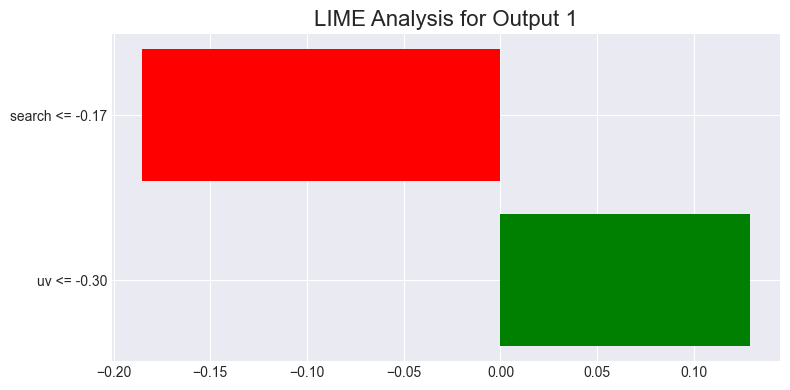

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value 

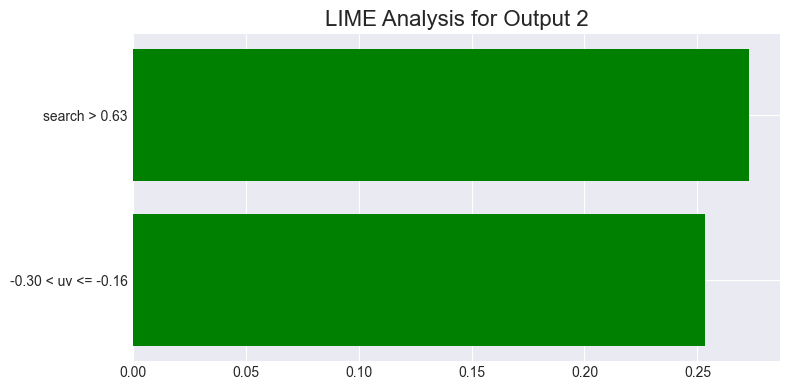

/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value 

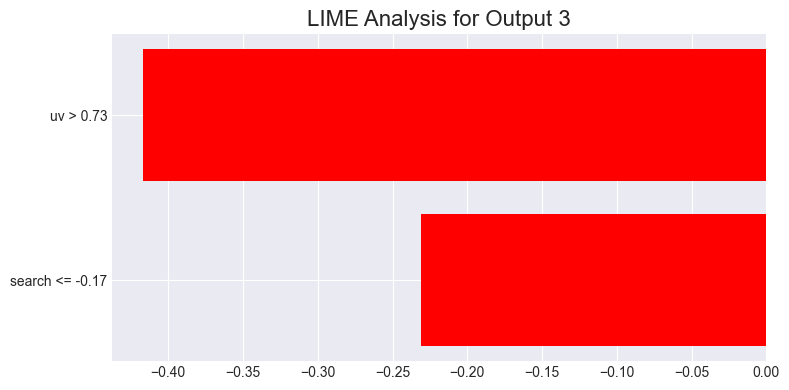

/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value 

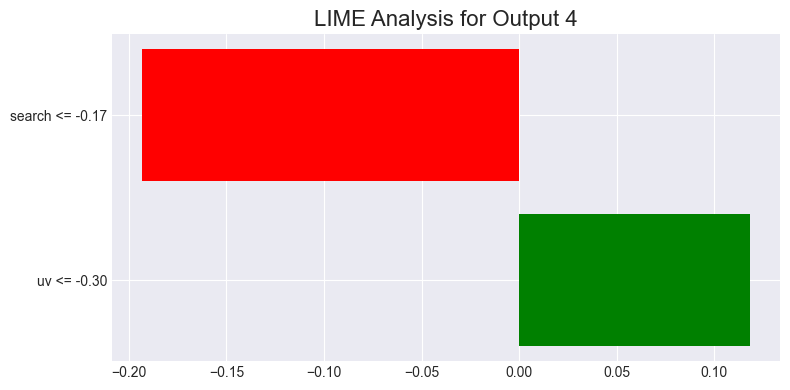

In [30]:
# LIME分析
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=['uv', 'search'],
    class_names=[str(i) for i in range(material_dim)],
    discretize_continuous=True
)
# 设置全局风格（可选）
plt.style.use('seaborn-v0_8-darkgrid')

# LIME 分析 + 图像设置
for i in range(4):
    exp = explainer_lime.explain_instance(
        X_test[i],
        lambda x: final_model.predict(x)[0],
        num_features=2
    )
    
    fig = exp.as_pyplot_figure()
    
    # 设置图像大小（单位：英寸）与 DPI
    fig.set_size_inches(8, 4)  # 宽8英寸，高4英寸（可调）
    plt.title(f'LIME Analysis for Output {i+1}', fontsize=16)
    # 显示图像
    plt.tight_layout()
    plt.show()
